In [1]:
import processing.basic_stats
import processing.user_stats
import processing.meta_stats as ms

import seaborn as sns
import matplotlib.pyplot as plt
import yaml

from datetime import datetime
from utils.utils import print_data_example, preprocess_text, get_tweet_timestamp, separate_text_by_classes, fetch_import_module

sns.set_style("whitegrid", {'axes.grid' : False, 'axes.linewidth':0})

In [1]:
!pip install krippendorff

  Using cached krippendorff-0.4.0-py3-none-any.whl (17 kB)
You should consider upgrading via the '/home/ubuntu/anaconda3/bin/python -m pip install --upgrade pip' command.


# 3. AnnotationPerspective

## Data loading

In [2]:
import pandas as pd
import numpy as np
import krippendorff

In [23]:
data_annotations =  "./data/Vidgen_2020/0_original/hs_AsianPrejudice_40kdataset_cleaned_anonymized.tsv"
data_gold =  "./data/Vidgen_2020/0_original/hs_AsianPrejudice_20kdataset_cleaned_anonymized.tsv"

In [26]:
df_gold = pd.read_csv(data_gold, sep="\t")
df_gold = df_gold[['id','expert']]
df_gold['name'] = 'expert'
df_gold = df_gold.pivot(index='name', columns='id', values='expert')
df_gold = df_gold.reindex(sorted(df_gold.columns), axis=1)
df_gold.head()

id,idstr_1212372663416639488,idstr_1212374922993053696,idstr_1213452156251987973,idstr_1213471445294075909,idstr_1213494381073711105,idstr_1213500414575800321,idstr_1213500578174648320,idstr_1213507843988418560,idstr_1213513217902727168,idstr_1213518180699607045,...,idstr_1239940647706144768,idstr_1239940735287406592,idstr_1239940749686259712,idstr_1239940762357227520,idstr_1239940769349169152,idstr_1239940780141264896,idstr_1239940814714933248,idstr_1239940871002472448,idstr_1239940881123291136,idstr_1239940979546828800
name,,,,,,,,,,,,,,,,,,,,,
expert,none_of_the_above,none_of_the_above,none_of_the_above,none_of_the_above,entity_directed_hostility,entity_directed_criticism,none_of_the_above,none_of_the_above,none_of_the_above,discussion_of_eastasian_prejudice,...,none_of_the_above,entity_directed_hostility,entity_directed_criticism,none_of_the_above,none_of_the_above,none_of_the_above,none_of_the_above,none_of_the_above,none_of_the_above,entity_directed_hostility


In [4]:
df = pd.read_csv(data_annotations, sep="\t")
df.head()

,id,text,text.clean,EA relevant,COVID relevant,hashtags,primary.actual,cleaned.target,threatening,dehumanization,interpersonal,slurs,annotation.id,annotator
0,idStr_1212372663416639488,@CNN No doubt a ChiNa female. #shameonchina #B...,@cnn no doubt a china female. HASHTAG_EASTASIA...,yes,no,hashtags_not_used_at_all_to_identify_themes,none_of_the_above,NaN,NaN,NaN,NaN,NaN,id.annotation.26012,annotator_gbEGjSAk6r
1,idStr_1212372663416639488,@CNN No doubt a ChiNa female. #shameonchina #B...,@cnn no doubt a china female. HASHTAG_EASTASIA...,yes,no,hashtags_not_used_at_all_to_identify_themes,none_of_the_above,NaN,NaN,NaN,NaN,NaN,id.annotation.25013,annotator_GNZuCtwed3
2,idStr_1212374922993053696,@KongTsungGan The #HongKongPoliceBrutality is ...,@kongtsunggan the HASHTAG_EASTASIA is happenin...,yes,yes,hashtags_only_used_to_identify_covid_relevance,none_of_the_above,NaN,NaN,NaN,NaN,NaN,id.annotation.38964,annotator_cYKSVBW4HD
3,idStr_1212374922993053696,@KongTsungGan The #HongKongPoliceBrutality is ...,@kongtsunggan the HASHTAG_EASTASIA is happenin...,yes,no,hashtags_not_used_at_all_to_identify_themes,none_of_the_above,NaN,NaN,NaN,NaN,NaN,id.annotation.37964,annotator_CAgNlUizNm
4,idStr_1213452156251987973,Afraid. #ChinaPneumonia,afraid. #HASHTAG,no,no,hashtags_not_used_at_all_to_identify_themes,none_of_the_above,NaN,NaN,NaN,NaN,NaN,id.annotation.29588,annotator_vDe7GN0NrL


In [15]:
mapping = dict()
for i, elem in enumerate(set(df['primary.actual'].to_list())):
    mapping[elem] = i
mapping[np.nan] = np.nan
mapping

{'none_of_the_above': 0,
 'discussion_of_eastasian_prejudice': 1,
 'entity_directed_criticism': 2,
 'counter_speech': 3,
 'entity_directed_hostility': 4,
 nan: nan}

In [21]:
df1 = df[['id', 'annotator','primary.actual']]
df1 = df1.pivot(index='annotator', columns='id', values='primary.actual')
df1 = df1.reindex(sorted(df1.columns), axis=1)
df1.head()

id,idStr_1212372663416639488,idStr_1212374922993053696,idStr_1213452156251987973,idStr_1213471445294075909,idStr_1213494381073711105,idStr_1213500414575800321,idStr_1213500578174648320,idStr_1213507843988418560,idStr_1213513217902727168,idStr_1213518180699607045,...,idStr_1239940647706144768,idStr_1239940735287406592,idStr_1239940749686259712,idStr_1239940762357227520,idStr_1239940769349169152,idStr_1239940780141264896,idStr_1239940814714933248,idStr_1239940871002472448,idStr_1239940881123291136,idStr_1239940979546828800
annotator,,,,,,,,,,,,,,,,,,,,,
annotator_CAgNlUizNm,NaN,none_of_the_above,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
annotator_E3dsmnSPob,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none_of_the_above,NaN,NaN
annotator_GAJVvVF2Pq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,none_of_the_above,NaN,NaN,NaN
annotator_GDWGBWY8Fi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,none_of_the_above,NaN,NaN,...,NaN,NaN,NaN,NaN,none_of_the_above,none_of_the_above,NaN,NaN,NaN,NaN
annotator_GNZuCtwed3,none_of_the_above,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



print("Example from http://en.wikipedia.org/wiki/Krippendorff's_Alpha")
print()
reliability_data_str = (
    "*    *    *    *    *    3    4    1    2    1    1    3    3    *    3",  # coder A
    "1    *    2    1    3    3    4    3    *    *    *    *    *    *    *",  # coder B
    "*    *    2    1    3    4    4    *    2    1    1    3    3    *    4",  # coder C
)
print('\n'.join(reliability_data_str))
print()

reliability_data = [[np.nan if v == '*' else int(v) for v in coder.split()] for coder in reliability_data_str]

print("Krippendorff's alpha for nominal metric: ", krippendorff.alpha(reliability_data=reliability_data,
                                                                      level_of_measurement='nominal'))
print("Krippendorff's alpha for interval metric: ", krippendorff.alpha(reliability_data=reliability_data))


In [31]:
annotations_np = df1.values.tolist()
annotations = []
for i in range(len(annotations_np)):
    annotator = []
    for j in range(len(annotations_np[0])):
        annotator.append(mapping[annotations_np[i][j]])
    annotations.append(annotator)

In [32]:
print("Krippendorff's alpha for nominal metric: ", krippendorff.alpha(reliability_data=annotations,
                                                                      level_of_measurement='nominal'))

Krippendorff's alpha for nominal metric:  0.5430673500456364


In [29]:
gold_np = df_gold.values.tolist()
gold = []
for i in range(len(gold_np)):
    annotator = []
    for j in range(len(gold_np[0])):
        annotator.append(mapping[gold_np[i][j]])
    gold.append(annotator)

In [34]:
alphas = []
for annotator in annotations:
    to_compare = [annotator,gold[0]]
    alphas.append(krippendorff.alpha(reliability_data=to_compare,
                                                                      level_of_measurement='nominal'))

In [36]:
alphas = sorted(alphas, reverse=True)

In [67]:
alphas

[0.8468494922193877,
 0.8448840758049095,
 0.8446532688104694,
 0.8436034176851147,
 0.8411696803692439,
 0.8406177132337902,
 0.8226086497563923,
 0.8145124056790326,
 0.8063277082566068,
 0.8051413173636255,
 0.7792785776629084,
 0.7784874964273213,
 0.7715379517527777,
 0.7571745717943317,
 0.7108955096652455,
 0.7104090378947772,
 0.7063675470627591,
 0.6947593524121478,
 0.6921888555561405,
 0.6881982814305456,
 0.6870673323050938,
 0.6824557881803281,
 0.6469906307214799,
 0.6469146685694103,
 0.6352294273183705,
 0.563551396831728]

In [39]:
list(range(len(alphas)))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

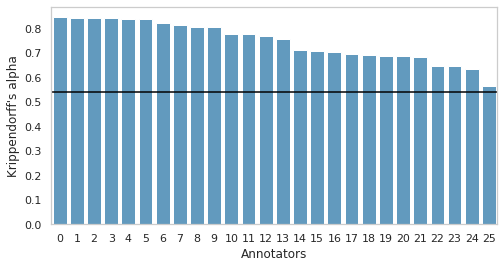

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from time import gmtime, strftime

colors = sns.color_palette("Blues")
sns.set_style("whitegrid", {'axes.grid' : False, 'axes.linewidth':0})

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax = sns.barplot(x=list(range(len(alphas))), y=alphas, color=colors[3])
ax.set(xlabel='Annotators', ylabel='Krippendorff\'s alpha')
line = ax.axhline(krippendorff.alpha(reliability_data=annotations,level_of_measurement='nominal'), color='black')


In [66]:
path_fig = "./results/"+strftime("%y%m%d", gmtime())+ "-" + "-".join(['Vidgen']).replace(" ","_")
fig.savefig(path_fig + "-inter-rater-reliability.pdf", bbox_inches='tight', dpi=300)
fig.savefig(path_fig + "-inter-rater-reliability.png", bbox_inches='tight', dpi=300)
fig.savefig(path_fig + "-inter-rater-reliability.eps", bbox_inches='tight', dpi=600)